Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


437/437 ━━━━━━━━━━━━━━━━━━━━ 95s 155ms/step - accuracy: 0.7232 - loss: 0.6428 - val_accuracy: 0.7138 - val_loss: 0.9573 - learning_rate: 3.0000e-04
Epoch 2/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 118ms/step - accuracy: 0.8007 - loss: 0.4878 - val_accuracy: 0.6918 - val_loss: 0.6531 - learning_rate: 3.0000e-04
Epoch 3/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 53s 118ms/step - accuracy: 0.8199 - loss: 0.4642 - val_accuracy: 0.8379 - val_loss: 0.4324 - learning_rate: 3.0000e-04
Epoch 4/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.8337 - loss: 0.4452 - val_accuracy: 0.6860 - val_loss: 0.6241 - learning_rate: 3.0000e-04
Epoch 5/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 116ms/step - accuracy: 0.8470 - loss: 0.4274 - val_accuracy: 0.7176 - val_loss: 0.6093 - learning_rate: 3.0000e-04
Epoch 6/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 52s 117ms/step - accuracy: 0.8471 - loss: 0.4262 - val_accuracy: 0.8307 - val_loss: 0.4675 - learning_rate: 3.0000e-04
Epoch 7/30
437/437 ━━━━━━━━━━━━━━━━━━━━ 51s 115ms/step - 

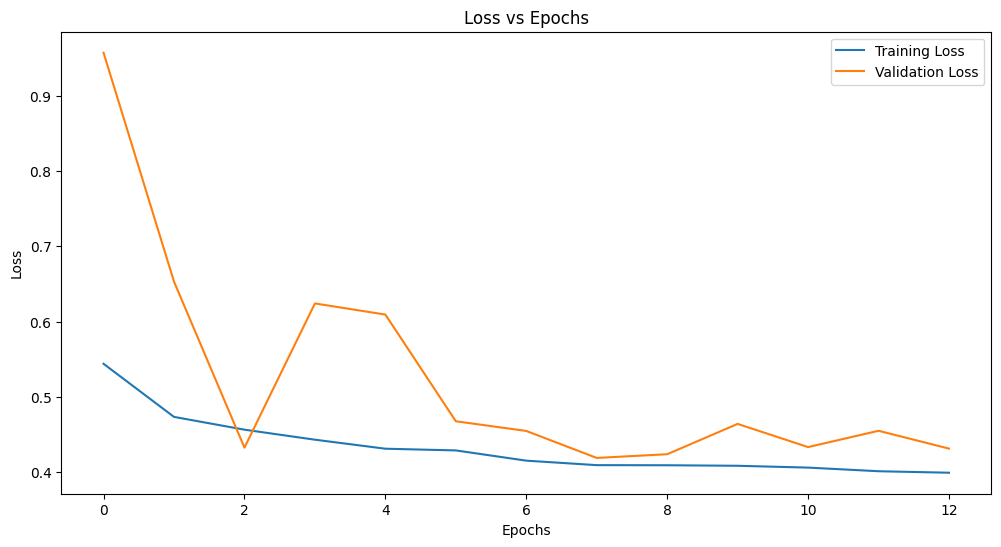

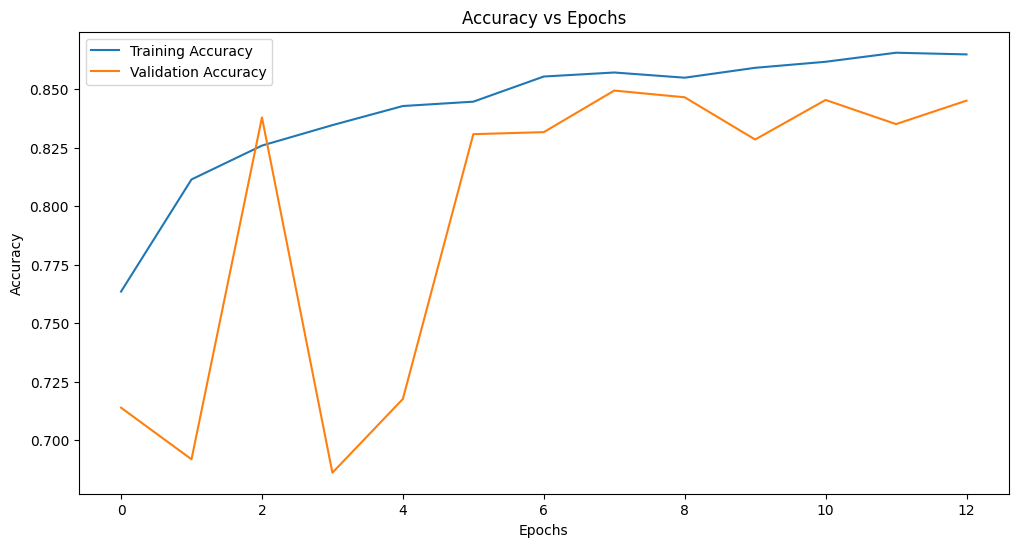

In [2]:

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, MaxPooling2D,
    Dense, Dropout, Reshape, Lambda, Embedding,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D
)
from tensorflow.keras.models import Model

import os
import time
import logging
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set up logging
# log_dir = '/kaggle/working/'
# os.makedirs(log_dir, exist_ok=True)
# log_file = os.path.join(log_dir, 'hybrid_model_training.log')
# logging.basicConfig(
#     filename=log_file,
#     level=logging.INFO,
#     format='%(asctime)s - %(levelname)s - %(message)s'
# )

class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = tf.keras.layers.Dense(units=projection_dim)
        self.position_embedding = tf.keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def create_hybrid_model(input_shape=(128, 128, 3), patch_size=16, num_patches=64, projection_dim=256,
                        transformer_layers=4, num_heads=8, dropout_rate=0.1):
    # Input layer
    inputs = Input(shape=input_shape)

    # CNN Feature Extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Ensure the output is 4D before patch extraction
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Patch Extraction Layer
    def extract_patches(x):
        return tf.image.extract_patches(
            images=x,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )

    patches = Lambda(extract_patches)(x)

    # Reshape patches
    patch_dims = patches.shape[-1]
    num_patches = (x.shape[1] // patch_size) * (x.shape[2] // patch_size)
    patches = Reshape((-1, patch_dims))(patches)

    # Patch Embedding
    x = Dense(projection_dim)(patches)

    # Add positional embeddings
    positions = tf.range(start=0, limit=num_patches, delta=1)
    position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)(positions)
    x = x + tf.expand_dims(position_embedding, axis=0)

    # Transformer Blocks
    for _ in range(transformer_layers):
        # Layer normalization and multi-head attention
        x_norm = LayerNormalization(epsilon=1e-6)(x)
        attention_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=projection_dim // num_heads
        )(x_norm, x_norm)
        x = x + attention_output

        # MLP
        mlp_norm = LayerNormalization(epsilon=1e-6)(x)
        mlp = Dense(projection_dim * 2, activation='gelu')(mlp_norm)
        mlp = Dropout(dropout_rate)(mlp)
        mlp = Dense(projection_dim)(mlp)
        x = x + mlp

    # Global average pooling and classification
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)

    # Final classification layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def load_and_preprocess_data(data_dir):
    """
    Load images and labels from training directory
    Returns X (images), y (labels)
    """
    images = []
    labels = []

    for label, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)

            # Read and resize image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = img_array / 255.0  # Normalize

            images.append(img_array)
            labels.append(label)

    return np.array(images), np.array(labels)

def create_dynamic_validation_generator(X_train, y_train, batch_size=32):
    """
    Create a dynamic validation generator using train_test_split
    """
    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # No augmentation for validation
    val_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=batch_size,
        shuffle=True
    )

    val_generator = val_datagen.flow(
        X_val, y_val,
        batch_size=batch_size,
        shuffle=False
    )

    return train_generator, val_generator

def create_test_generator(test_dir, batch_size=32):
    """
    Create a test generator from a specified directory
    """
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    return test_generator

def train_model(model, train_generator, validation_generator, epochs=30):
    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=3e-4,
        weight_decay=1e-4
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"],
    )

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'best_hybrid_model.keras',
            monitor="val_loss",
            save_best_only=True
        ),
        # keras.callbacks.CSVLogger(
        #     os.path.join(log_dir, 'hybrid_training.csv')
        # )
    ]

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=30,
        callbacks=callbacks,
        verbose=1
    )
    return history


def plot_performance(history):
    # Extracting the loss and accuracy values
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plotting the loss
    plt.figure(figsize=(12, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot
    plt.savefig('training_performance.png')

    # Display the plot
    plt.show()

    # Plotting the accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Save the plot
    plt.savefig('training_performance.png')

    # Display the plot
    plt.show()

    return history, plot_performance

def evaluate_model(model, test_generator, y_test):
    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

    # Get true labels and predictions
    y_true = y_test
    y_pred = (model.predict(test_generator) > 0.5).astype("int32").flatten()

    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return test_loss, test_accuracy, accuracy, precision, recall, f1

def main():
    # Load and preprocess data
    train_data_dir = '/kaggle/input/chest-x-ray-images/FinalData (copy)/FinalData (copy)/train'
    test_data_dir = '/kaggle/input/chest-x-ray-images/FinalData (copy)/FinalData (copy)/test'
    X_train, y_train = load_and_preprocess_data(train_data_dir)
    X_test, y_test = load_and_preprocess_data(test_data_dir)

    # Create dynamic validation generator
    train_generator, validation_generator = create_dynamic_validation_generator(X_train, y_train)

    # Create and train model
    vit_model = create_hybrid_model()
    start_time = time.time()
    history = train_model(vit_model, train_generator, validation_generator)
    execution_time = time.time() - start_time

    # Log training time
    logging.info(f'Hybrid Model - Training Time: {execution_time:.2f} seconds')

    # Evaluate model on test set
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)
    test_loss, test_accuracy, accuracy, precision, recall, f1 = evaluate_model(vit_model, test_generator, y_test)

    # Log and print results
    logging.info(f'Hybrid Model - Test Loss: {test_loss:.4f}')
    logging.info(f'Hybrid Model - Test Accuracy: {test_accuracy:.4f}')
    logging.info(f'Hybrid Model - Accuracy: {accuracy:.4f}')
    logging.info(f'Hybrid Model - Precision: {precision:.4f}')
    logging.info(f'Hybrid Model - Recall: {recall:.4f}')
    logging.info(f'Hybrid Model - F1 Score: {f1:.4f}')

    print(f'Hybrid Model - Test Loss: {test_loss:.4f}')
    print(f'Hybrid Model - Test Accuracy: {test_accuracy:.4f}')
    print(f'Hybrid Model - Accuracy: {accuracy:.4f}')
    print(f'Hybrid Model - Precision: {precision:.4f}')
    print(f'Hybrid Model - Recall: {recall:.4f}')
    print(f'Hybrid Model - F1 Score: {f1:.4f}')

    plot_performance(history)

if __name__ == '__main__':
    main()

